In [75]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np

In [76]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
# tr.set_default_dtype(tr.float)
# tr.set_default_device(device)
#hyperparameters
runs = 10
batch_size = 1024
epoch = 400
t_update = 10
g = 0.8
max_steps = 400

target = [0.5,0]
deviation = 0.05
target_area = [[target[0]-deviation,target[0]+deviation],
               [target[1]-deviation,target[1]+deviation]]
U0 = 0.4
lstm_hidden_size = 0#8
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.dpi': 250})

char_size = 3
dt = 0.03#75

In [77]:
def d(L):
    direction_mapping = [
        
        tr.tensor(0,dtype=tr.float).to(device),
        # tr.tensor(1/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi/2,dtype=tr.float).to(device), 
        # tr.tensor(3/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi,dtype=tr.float).to(device), 
        # tr.tensor(5/4*tr.pi,dtype=tr.float).to(device),
        tr.tensor(3/2 * tr.pi,dtype=tr.float).to(device),
        # tr.tensor(7/4 * tr.pi,dtype=tr.float).to(device)
    ]
    return tr.stack(direction_mapping).to(device)[L]

def U(U0,x,y):
    bool = (x**2+y**2)**0.5>0.5
    P = 16*U0*(x**2+y**2-0.25)**2
    P[bool] = 0
    return P
    
def force(x,y,type='mexican'):
    if type == 'lorenzian':
        if isinstance(x, tr.Tensor):
            F_x = tr.zeros(y.shape).to(device)
            F_y = U0/(1+6*x**2)
            return F_x, F_y
        else:
            U,V = np.zeros(y.shape), U0/(1+6*x**2)
            return U,V
    if type == 'mexican':
        if isinstance(x, tr.Tensor):
            r = tr.sqrt(x**2+y**2)
            bool = r>0.4
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            # f = tr.stack([fr*x,fr*y],dim=1).to(device)
            F_x = fr*x
            F_y = fr*y
            return F_x,F_y
        else:
            r = np.sqrt(x**2+y**2)
            bool = r>0.5
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            U,V = fr*x,fr*y
            #U,V = x*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2)), y*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2))
            return U,V
def plot_potential():
    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.scatter(-0.5,0,c='black',label='start',marker='D')    
    plt.scatter(0.5,0,c='black',label='goal',marker='x')


    X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))

    Potential = U(U0,X1,Y1)/U0
    # _,forcefield = force(X1,Y1)
    plt.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
    colorbar = plt.colorbar()
    colorbar.set_label(r'$U/U_0$',labelpad=10,fontsize = 20)
    colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

In [78]:
def load_data(fname):
    Runs_Loss_total = np.load(fname+ 'Runs_Loss_total.npy')
    Runs_success_episodes = np.load(fname+ 'Runs_success_episodes.npy')
    Runs_travel_time = np.load(fname+'Runs_travel_time.npy')

    Runs_avg_loss = np.load(fname+'Runs_avg_loss.npy')
    Runs_avg_succ = np.load(fname+'Runs_avg_succ.npy')
    Runs_avg_time = np.load(fname+'Runs_avg_time.npy')

    return Runs_Loss_total, Runs_success_episodes, Runs_travel_time, Runs_avg_loss, Runs_avg_succ, Runs_avg_time


In [79]:
fname1 = 'With_Noise_test_2_runs10_char_size_3_batch_size_1024_U_0_0.4_'
fname2 = 'No_Noise_test_2_runs10_batch_size_1024_U_0_0.4_'
Runs_Loss_total, Runs_success_episodes, Runs_travel_time, Runs_avg_loss, Runs_avg_succ, Runs_avg_time = load_data(fname1)

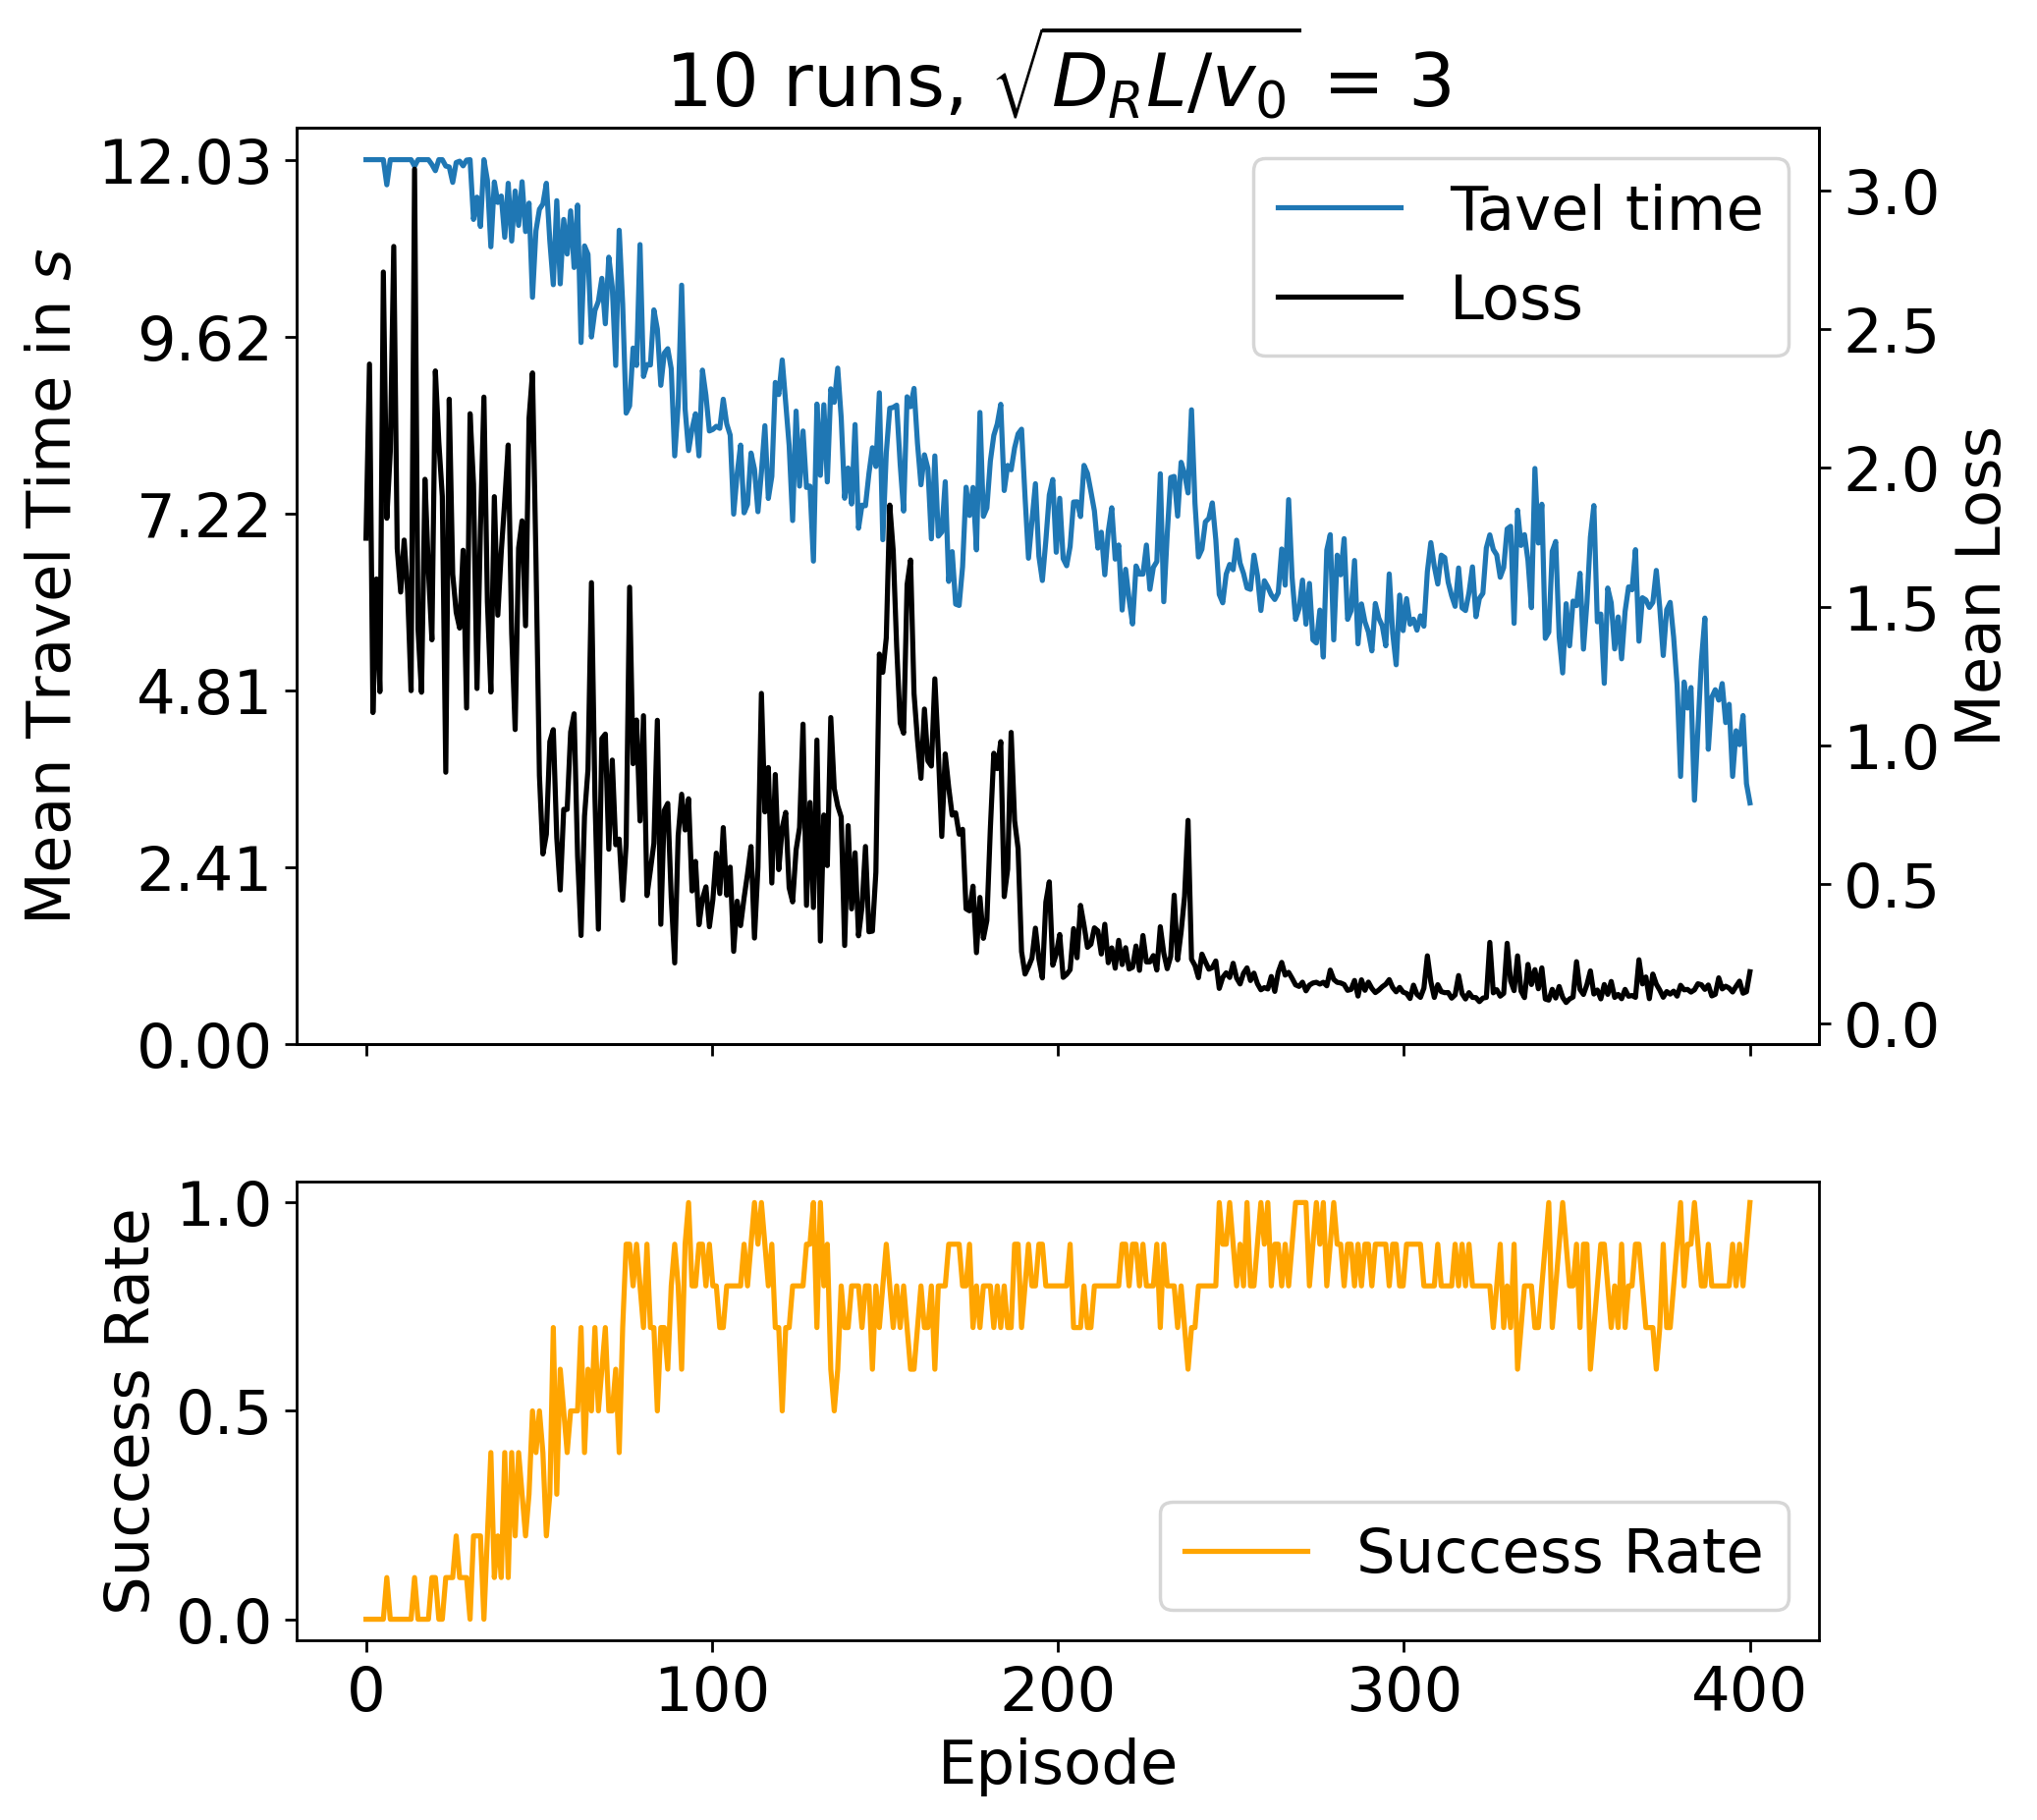

In [80]:
# print(Loss_total.shape)
fig, (ax1,ax3) = plt.subplots(2,1,sharex=True,figsize=(8,8),height_ratios=[2,1])#dpi=300

ax2 = ax1.twinx()
X = np.linspace(0,epoch,epoch)
yticks = np.round(np.linspace(0,np.max(Runs_avg_time),6),2)
ax2.plot(X,Runs_avg_loss,label = 'Loss', c='black')
ax3.plot(X, Runs_avg_succ, label = 'Success Rate',c='orange')#,marker='.'
ax1.plot(X,Runs_avg_time, label = 'Tavel time')
ax3.set_xlabel('Episode')
ax2.set_ylabel('Mean Loss')
ax1.set_ylabel('Mean Travel Time in '+r'$s$')
ax1.set_yticks(yticks)
ax1.set_title(str(runs) +' runs, ' + r'$\sqrt{D_RL/v_0}$ = '+ str(char_size))
ax3.set_ylabel('Success Rate')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax1.legend(handles, labels)
ax3.legend(loc='lower right')
# ax1.legend()
# ax3.legend(loc='lower right')
# plt.legend(['Loss','Success Rate'])
plt.show()